In [11]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime
import itertools

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy import ndimage, misc

import keras
from keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import utils as np_utils

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Reshape, Conv1D, MaxPooling1D, AveragePooling1D,\
UpSampling1D, InputLayer
from tensorflow.keras.layers import Conv2D,\
    MaxPool2D, Conv2DTranspose, Input, Activation
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MaxAbsScaler
import joblib
from sklearn.neighbors import LocalOutlierFactor
from sklearn import cluster, datasets
import tensorflow as tf
import random
import os
import cv2
import matplotlib.image as mpimg
%matplotlib inline

In [12]:
root_path = "../data/"
path_img_ok = root_path + "/Images/OK/"
path_img_ko = root_path + "/Images/NG/"
path_msk_ok = root_path + "/Masks/OK_MSK/"
path_msk_ko = root_path + "/Masks/NG_MSK/"
print(path_img_ok)
print(path_img_ko)
print(path_msk_ok)
print(path_msk_ko)

../data//Images/OK/
../data//Images/NG/
../data//Masks/OK_MSK/
../data//Masks/NG_MSK/


In [13]:
def print_random_images(img_folder):
    for i in range(5):
        lst = os.listdir(img_folder)
        lst.sort()
        file = lst[i]
        image_path = os.path.join(img_folder, file)
        img = mpimg.imread(image_path)
        ax = plt.subplot(1, 5, i+1)
        ax.title.set_text(file)
        plt.imshow(img)

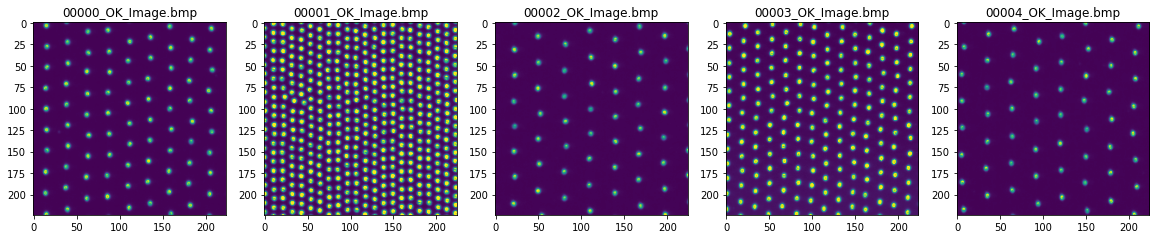

In [14]:
plt.figure(figsize = (20, 20))
print_random_images(path_img_ok)

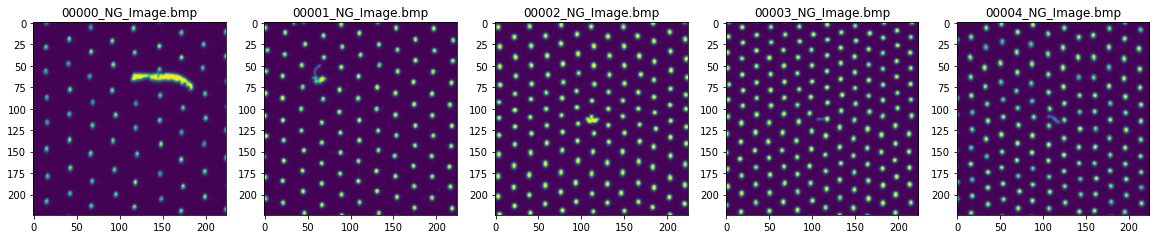

In [15]:
plt.figure(figsize = (20, 20))
print_random_images(path_img_ko)

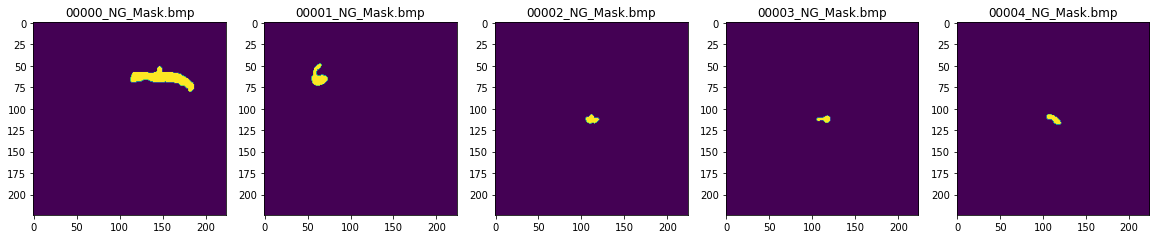

In [16]:
plt.figure(figsize = (20, 20))
print_random_images(path_msk_ko)

In [17]:
img_dataset_ok = []
img_dataset_ko = []
msk_dataset_ok = []
msk_dataset_ko = []

In [18]:
IMG_WIDTH=224
IMG_HEIGHT=224

def create_dataset(img_folder, bnw, binary):
    img_data_array = []
    color_str = cv2.COLOR_BGR2GRAY
    color_int = 1
    if(bnw):
        color_str = cv2.cv2.IMREAD_GRAYSCALE
        color_int = 1
    for file in sorted(os.listdir(img_folder)):
            image_path = os.path.join(img_folder, file)
            image = cv2.imread(image_path, color_str)
            image = cv2.resize(image, (IMG_WIDTH, IMG_WIDTH), interpolation = cv2.INTER_AREA)
            if(not(bnw)):
                clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
                image = clahe.apply(image)
                kernel = np.ones((3,3),np.uint8)
                image = cv2.dilate(image,kernel,iterations = 1)
            image = np.array(image)
            image = image.astype('float32')
            image /= 255
            image = np.reshape(image, (IMG_WIDTH,IMG_HEIGHT,color_int))
            
            # go back 2 3 channels
            if not bnw:
                image = image.repeat(3,axis=-1)
            
            if(bnw):
                image = cv2.threshold(image, 0, 1, cv2.THRESH_BINARY)[1]
            if(binary):
                image = image.tobytes()
            img_data_array.append(image)
    return img_data_array

In [19]:
# extract the image array and class name
img_dataset_ok = create_dataset(path_img_ok, False, False)
img_dataset_ko = create_dataset(path_img_ko, False, False)
msk_dataset_ok = create_dataset(path_msk_ok, True, False)
msk_dataset_ko = create_dataset(path_msk_ko, True, False)

img_dataset_ok_bin = create_dataset(path_img_ok, False, True)
img_dataset_ko_bin = create_dataset(path_img_ko, False, True)
msk_dataset_ok_bin = create_dataset(path_msk_ok, True, True)
msk_dataset_ko_bin = create_dataset(path_msk_ko, True, True)

(224, 224, 3)


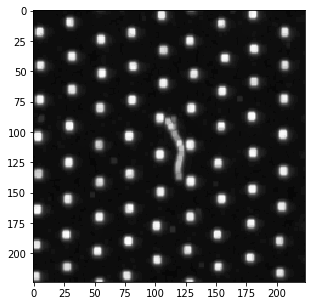

In [20]:
plt.figure(figsize = (5, 5))
plt.imshow(img_dataset_ko[8], interpolation='nearest')
print(img_dataset_ko[0].shape)

0.0 1.0


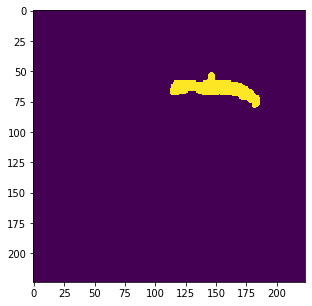

In [21]:
plt.figure(figsize = (5, 5))
plt.imshow(msk_dataset_ko[0], interpolation='nearest')
print(np.amin(msk_dataset_ko[0]), np.amax(msk_dataset_ko[0]))
#print(msk_dataset_ko[0].shape)

In [22]:
df_img_dataset_ok = pd.DataFrame(columns = ['image','label'])
df_img_dataset_ok['image'] = img_dataset_ok_bin
df_img_dataset_ok['label'] = 0
#df_img_dataset_ok

In [23]:
df_img_dataset_ko = pd.DataFrame(columns = ['image','label'])
df_img_dataset_ko['image'] = img_dataset_ko_bin
df_img_dataset_ko['label'] = 1
#df_img_dataset_ko

In [24]:
df_msk_dataset_ok = pd.DataFrame(columns = ['mask'])
df_msk_dataset_ok['mask'] = msk_dataset_ok_bin
#df_msk_dataset_ok['label'] = 0
#df_msk_dataset_ok

In [25]:
df_msk_dataset_ko = pd.DataFrame(columns = ['mask'])
df_msk_dataset_ko['mask'] = msk_dataset_ko_bin
#df_msk_dataset_ko['label'] = 1
#df_msk_dataset_ok

In [26]:
df_img_dataset_tot = pd.concat([df_img_dataset_ok,df_img_dataset_ko], ignore_index=True)
df_msk_dataset_tot = pd.concat([df_msk_dataset_ok,df_msk_dataset_ko], ignore_index=True)

In [27]:
df_dataset_tot = pd.merge(df_img_dataset_tot, df_msk_dataset_tot, left_index=True, right_index=True)
#df_dataset_tot = df_dataset_tot.rename({'image_x': 'image', 'image_y': 'mask'}, axis=1)

In [28]:
df_dataset_tot

,image,label,mask
0,b'\xf1\xf0p=\xf1\xf0p=\xf1\xf0p=\xf1\xf0p=\xf1...,0,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...
1,b'\xab\xaa\xaa>\xab\xaa\xaa>\xab\xaa\xaa>\xab\...,0,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...
2,b'\xa1\xa0\xa0=\xa1\xa0\xa0=\xa1\xa0\xa0=\xa1\...,0,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...
3,b'\x89\x88\x88=\x89\x88\x88=\x89\x88\x88=\xb9\...,0,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...
4,b'\xa1\xa0\xa0=\xa1\xa0\xa0=\xa1\xa0\xa0=\xe9\...,0,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...
...,...,...,...
817,b'\xd1\xd0P=\xd1\xd0P=\xd1\xd0P=\xd1\xd0P=\xd1...,1,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...
818,b'\xd1\xd0P=\xd1\xd0P=\xd1\xd0P=\xd1\xd0P=\xd1...,1,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...
819,b'\x99\x98\x98=\x99\x98\x98=\x99\x98\x98=\x99\...,1,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...
820,b'\xd1\xd0P=\xd1\xd0P=\xd1\xd0P=\xd1\xd0P=\xd1...,1,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...


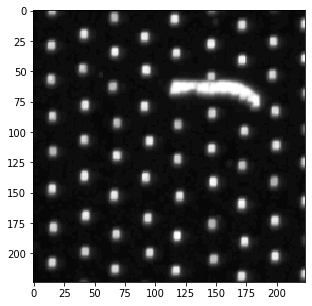

In [29]:
plt.figure(figsize = (5, 5))
img = np.frombuffer(df_dataset_tot[df_dataset_tot.label==1]['image'].iloc[0], dtype=np.float32)
img = np.reshape(img, (IMG_WIDTH,IMG_HEIGHT,3))
plt.imshow(img, interpolation='nearest')

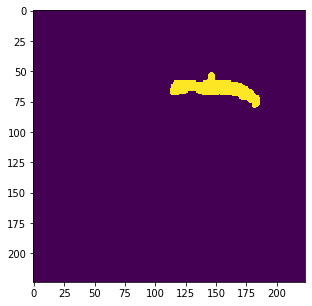

In [30]:
plt.figure(figsize = (5, 5))
img = np.frombuffer(df_dataset_tot[df_dataset_tot.label==1]['mask'].iloc[0], dtype=np.float32)
img = np.reshape(img, (IMG_WIDTH,IMG_HEIGHT,1))
plt.imshow(img, interpolation='nearest')

In [31]:
df_dataset_tot = df_dataset_tot.sample(frac=1).reset_index(drop=True)

In [32]:
df_dataset_train, df_dataset_test = train_test_split(df_dataset_tot, test_size=0.97, random_state=25)

In [33]:
df_dataset_val, df_dataset_test = train_test_split(df_dataset_test, test_size=0.90, random_state=25)

In [34]:
df_dataset_train.groupby("label")['image'].count()

label
0    15
1     9
Name: image, dtype: int64

In [35]:
len(df_dataset_train)

24

In [36]:
df_dataset_test.groupby("label")['image'].count()

label
0    343
1    376
Name: image, dtype: int64

In [37]:
df_dataset_val.groupby("label")['image'].count()

label
0    42
1    37
Name: image, dtype: int64

In [38]:
print(f"No. of training examples: {df_dataset_train.shape[0]}")
print(f"No. of testing examples: {df_dataset_test.shape[0]}")
print(f"No. of validation examples: {df_dataset_val.shape[0]}")

No. of training examples: 24
No. of testing examples: 719
No. of validation examples: 79


In [39]:
def convert_back(df, type, color_int):
    temp_arr = []
    for i in df[type].values:
        a = np.frombuffer(i, dtype=np.float32)
        a = a.reshape(IMG_WIDTH,IMG_HEIGHT,color_int)
        temp_arr.append(a)
        #print(a.shape)
    return temp_arr

img_train = convert_back(df_dataset_train, 'image', 3)
img_test = convert_back(df_dataset_test, 'image', 3)
img_val = convert_back(df_dataset_val, 'image', 3)

msk_train = convert_back(df_dataset_train, 'mask', 1)
msk_test = convert_back(df_dataset_test, 'mask', 1)
msk_val = convert_back(df_dataset_val, 'mask', 1)

print(len(img_train), len(msk_train))
print(len(img_test), len(msk_test))
print(len(img_val), len(msk_val))

print(img_train[0].shape, msk_train[0].shape)
print(img_test[0].shape, msk_test[0].shape)
print(img_val[0].shape, msk_val[0].shape)

24 24
719 719
79 79
(224, 224, 3) (224, 224, 1)
(224, 224, 3) (224, 224, 1)
(224, 224, 3) (224, 224, 1)


(224, 224, 3)


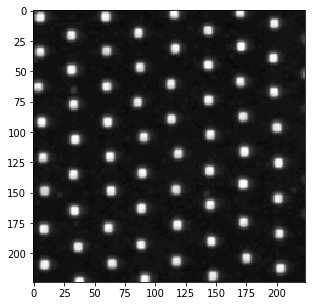

In [40]:
plt.figure(figsize = (5, 5))
plt.imshow(img_test[0], interpolation='nearest')
#print(img_test[0])
print(img_test[0].shape)

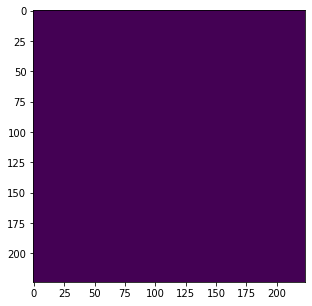

In [41]:
plt.figure(figsize = (5, 5))
plt.imshow(msk_test[0], interpolation='nearest')
#print(msk_test[0])

In [42]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 112x112   filters
    'block_3_expand_relu',   # 56x56
    'block_6_expand_relu',   # 28x28
    'block_13_expand_relu',  # 14x14
    'block_16_project',      # 7x7
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

#down_stack.trainable = False

2022-04-14 11:37:17.715414: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [43]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [44]:
#base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
#layer_names = [
#    'block_1_expand_relu',   # 64x64
#    'block_3_expand_relu',   # 32x32
#    'block_6_expand_relu',   # 16x16
#    'block_13_expand_relu',  # 8x8
#    'block_16_project',      # 4x4
#]
#base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
#down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

#down_stack.trainable = False

In [45]:
#from tensorflow_examples.models.pix2pix import pix2pix
#up_stack = [
#    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
#    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
#    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
#    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
#]

In [46]:
from tensorflow_examples.models.pix2pix import pix2pix
up_stack = [
    pix2pix.upsample(576, 3),  # 7x7 -> 14x14
    pix2pix.upsample(192, 3),  # 8x8 -> 16x16
    pix2pix.upsample(144, 3),  # 16x16 -> 32x32
    pix2pix.upsample(96, 3),   # 32x32 -> 64x64
]

In [ ]:
from examples.tensorflow_examples import models

In [ ]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[224, 224, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

# This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

    x = last(x)
    x = Activation("softmax")(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix

In [ ]:
import tensorflow.keras.metrics as tfm
from tensorflow.keras.callbacks import ReduceLROnPlateau


class IoUCustom(tfm.IoU):
    def __init__(self, from_logits=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._from_logits = from_logits

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true_new = y_true[:,:,:,0]
        y_true_new = y_true_new[..., tf.newaxis]
        y_pred_new = tf.argmax(y_pred, axis=-1)
        y_pred_new = y_pred_new[..., tf.newaxis]
        return super(tfm.IoU, self).update_state(y_true_new, y_pred_new, sample_weight)

In [ ]:
def iou_loss(y_true, y_pred):
    y_pred_new = y_pred[:,:,:,1:]
    num = tf.reduce_sum(y_true * y_pred_new)
    den = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred_new) - num
    
    return (1-tf.math.divide_no_nan(num,den))

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.8,
    patience=5,
    min_lr=1e-5,
    min_delta=0.0001,
    verbose=2
)

In [ ]:
OUTPUT_CLASSES = 2
from tensorflow.keras.optimizers import schedules, Adamax, Adam
optimizer_init = Adam(learning_rate = 0.002)
model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer=optimizer_init,
              loss=iou_loss,
              metrics=[IoUCustom(num_classes=2, target_class_ids=[1], name='iou')],
             )

In [ ]:
#tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask

In [ ]:
EPOCHS = 50

model_history = model.fit(
    x=np.array(img_train, np.float32) 
    ,y=np.array(msk_train, np.float32)
    ,epochs=EPOCHS
    #,steps_per_epoch=STEPS_PER_EPOCH
    #,validation_steps=VALIDATION_STEPS
    ,validation_data=(np.array(img_val, np.float32), np.array(msk_val, np.float32))
    ,callbacks=[reduce_lr]
    )

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(model_history.history['loss'])
axs[0].plot(model_history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].legend(['Train', 'Val'])

axs[1].plot(model_history.history['iou'])
axs[1].plot(model_history.history['val_iou'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].legend(['Train', 'Val'])

In [ ]:
score = model.evaluate(np.array(img_test, np.float32), np.array(msk_test, np.float32))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

-----------------------

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [ ]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [ ]:
for example in train_images.take(5):
    image, label = example[0], example[1]
    print(image.shape)
    print(label.shape)
    print(np.amin(label), np.amax(label))

In [ ]:
for example in dataset["train"].take(5):
    image, label = example["image"], example["segmentation_mask"]
    print(image.shape)
    print(label.shape)
    print(np.amin(label), np.amax(label))

In [ ]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_batches = test_images.batch(BATCH_SIZE)

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [ ]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[63], masks[63]
  display([sample_image, sample_mask])

In [ ]:
def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([2.0, 2.0, 1.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

In [ ]:
train_batches.map(add_sample_weights).element_spec
train_batches1 = train_batches.map(add_sample_weights)

In [ ]:
for example in train_batches1.take(1):
    image, label, weights = example[0], example[1], example[2]
    print(image.shape)
    print(label.shape)
    print(weights.shape)
    print(np.amin(label), np.amax(label))
    print(np.amin(weights), np.amax(weights))

In [ ]:
class_weights = tf.constant([1.0, 10.0])
class_weights = class_weights/tf.reduce_sum(class_weights)

In [ ]:
print(class_weights)

In [ ]:
tf.cast(img_train, tf.int32)
sample_weights = tf.gather(class_weights, indices=tf.cast(msk_train, tf.int32))

In [ ]:
print(type(sample_weights))
print(np.amin(sample_weights), np.amax(sample_weights))

In [8]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))


In [48]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

tensorflow==2.8.0
scipy==1.7.0
scikit-learn==0.24.2
pandas==1.3.1
numpy==1.21.1
matplotlib==3.4.2
keras==2.8.0
joblib==1.0.1
